### Newton Method for Logistic Regression

&nbsp;

Logistic regression is a simple model for binary classification. With a tiny modification, it can be applied to high dimension classification (Softmax regression). Logistic regression is usually in the form below.

$$h_\theta(x)=\frac {1}{1+e^{-\theta^Tx}}$$

$$J(\theta)= y log(h_\theta(x)) + (1-y) log(1-h_\theta(x))$$

In gradient descent

$$\theta:=\theta-\alpha\frac{\partial J(\theta)}{\partial \theta}=\theta-\alpha  (y-h_\theta(x)) \cdot x$$

In Newton method

$$\theta:=\theta-H^{-1} \cdot \nabla_\theta {J(\theta)}=\theta-\frac {\frac{\partial J(\theta)}{\partial \theta}} {\frac{\partial^2 J(\theta)}{\partial \theta^2}}=\theta- \frac {(y-h_\theta(x)) \cdot x}{h_\theta(x)(1-h_\theta(x)) \cdot x^2}$$

NM doesn't only skip the learning parameter $\alpha$ of gradient descent, but also comes with quicker convergence than GD. NM's mea culpa is the inverse of a Hessian matrix (Fisher information matrix in statistics). When dealing with high dimensional matrix, the computation cost of an inverse can be quite expensive.

Reference to Newton method

http://thelaziestprogrammer.com/sharrington/math-of-machine-learning/solving-logreg-newtons-method

In [1]:
import os
os.chdir('d:/')
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import copy

In [2]:
#formula of sigmoid function
def sigmoid(theta0,theta1,x):
    return 1/(1+np.e**(-1*(x*theta1+theta0)))

#newton method to fit logit regression
def newton_method(y,x):
    
    #stop is something set by us
    #the concept is similar to gradient descent
    #when our mean square error is smaller than stop
    #we reach convergence therefore stop
    #plz refer to my gradient descent file for explanation
    # https://github.com/je-suis-tm/machine-learning/blob/master/gradient%20descent.ipynb
    stop=0.000000001
    
    #we use pca to reduce our four dimension iris data into one
    #reference to pca
    # https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb
    pca_data=pd.DataFrame(PCA(n_components=1).fit_transform(x))[0]
    x_train,x_test,y_train,y_test=train_test_split(pca_data,y,test_size=0.3)
    
    #when we read csv,we may get str value instead of float
    #just convert to float from str
    y_train=copy.deepcopy(y_train.apply(lambda x: float(x)))
    y_test=copy.deepcopy(y_test.apply(lambda x: float(x)))

    #set our parameter theta as a vector
    #theta is the current parameter vector
    #theta_prev is the last parameter vector
    #we initialize theta_prev with the first example of training set
    theta_prev=np.mat([y_train.iloc[0],x_train.iloc[1]]).T
    theta=np.mat([0,0]).T
    
    #get the fitted value of y
    fitted=sigmoid(theta_prev.item(0),theta_prev.item(1),x_train.iloc[0])

    for i in range(1,len(y_train)):
        
        #calculate gradient and hessian matrix
        #hessian is just partial derivative matrix of gradient
        residual=y_train.iloc[i-1]-fitted
        gradient=np.mat([residual,residual*x_train.iloc[i-1]]).T
        hessian=np.mat([fitted*(1-fitted)*(x_train.iloc[i-1]**2),\
                       fitted*(1-fitted)*x_train.iloc[i-1],\
                       fitted*(1-fitted)*x_train.iloc[i-1],\
                       fitted*(1-fitted)]).reshape(2,2)

        #newton method formula
        theta=theta_prev+np.linalg.inv(hessian)*gradient
        
        fitted=sigmoid(theta.item(0),theta.item(1),x_train.iloc[i])
        
        if (y_train.iloc[i]-fitted)**2<stop:
            print('converged')
            break
            
        theta_prev=copy.deepcopy(theta)
    
    #calculate fitted y of test and train samples
    test=sigmoid(theta.item(0),theta.item(1),x_test)    
    curve=sigmoid(theta.item(0),theta.item(1),x_train)
    
    print('train accuracy: {}%'.format(len(
        y_train[curve==y_train])/len(y_train)*100))
    print('test accuracy: {}%'.format(len(
        y_test[test==y_test])/len(y_test)*100))
    print('intercept: %d'%(theta.item(0)))
    print('coefficient: %d'%(theta.item(1)))
    
    #plot logit curve and scatters of train and test samples
    plt.plot(sorted(x_train),sorted(curve),c='#009ab0',
             lw=2,label='logit',alpha=0.5)
    plt.scatter(x_test,y_test,c='#128a08',marker='o',
                alpha=0.5,s=85,label='test')
    plt.scatter(x_train,y_train,c='#ff0659',marker='*',
                alpha=0.2,s=85,label='train')
    plt.legend(loc='best')
    plt.title('newton method')
    plt.show()
    
    return theta

In [3]:
#using sklearn library
def logit(y,x):
    
    pca_data=PCA(n_components=1).fit_transform(x)

    x_train,x_test,y_train,y_test=train_test_split(pca_data,y,test_size=0.3)

    m=LR()
    result=m.fit(x_train,y_train)
    print('train accuracy: {}%'.format(m.score(x_train,y_train)*100))
    print('test accuracy: {}%'.format(m.score(x_test,y_test)*100))
    print('intercept: %s'%result.intercept_.item(0))
    print('coefficient: %s'%result.coef_.item(0))

    curve=sigmoid(result.intercept_.item(0),result.coef_.item(0),x_train)

    plt.plot(sorted(x_train),sorted(curve),
             c='#009ab0',lw=2,label='logit',alpha=0.5)
    plt.scatter(x_test,y_test,c='#128a08',marker='o',
                alpha=0.5,s=85,label='test')
    plt.scatter(x_train,y_train,c='#ff0659',marker='*',
                alpha=0.2,s=85,label='train')
    plt.legend(loc='best')
    plt.title('logit')
    plt.show()

### Run

In [4]:
df=pd.read_csv('iris.csv')

#make it a binary classification problem
df=df[df['type']!='Iris-virginica']

In [5]:
#convert text type into numerical type
df['regressand']=np.select([df['type']=='Iris-setosa',df['type']=='Iris-versicolor'],['0','1'])

In [6]:
x=pd.concat([df['sepal length'],
                 df['sepal width'],
                 df['petal length'],
                 df['petal width']],axis=1)
y=df['regressand']

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in double_scalars
  


converged
train accuracy: 95.71428571428572%
test accuracy: 96.66666666666667%
intercept: -36557931289088960
coefficient: 51749885124383608


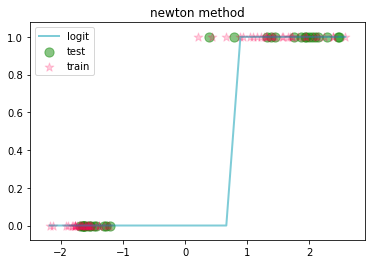

matrix([[-3.65579313e+16],
        [ 5.17498851e+16]])

In [7]:
#our implementation of newton method is not as good as sklearn
#sometimes we encounter singular matrix error
#the accuracy depends on how we split train and test samples
newton_method(y,x)

train accuracy: 100.0%
test accuracy: 100.0%
intercept: 0.38365796999300084
coefficient: 2.473980898665508


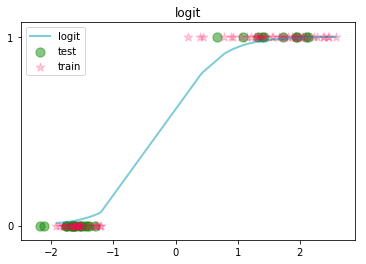

In [8]:
#sklearn logit always score 100% accuracy
logit(y,x)